<a href="https://colab.research.google.com/github/xvh422/L4-Project/blob/main/First_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install eagleSqlTools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import eagleSqlTools as sql
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable

con = sql.connect("vwg533", password = "FZtn087h")

In [2]:
sim_name = 'RefL0100N1504'
sim_size = 100.
    
# Construct and execute query for each simulation. This query returns the number of galaxies 
# for a given 30 pkpc aperture stellar mass bin (centered with 0.2 dex width). 
Query_1 = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

Query_2 = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr, \
            (AP.Mass_BH/AP.Mass_Star) as ratio \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star < 3.1622776601684e10 and \
            AP.Mass_Star > 1.0e10 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

Query_blue = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            (AP.SFR/AP.Mass_Star) > 5.0e-12 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

Query_red = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            (AP.SFR/AP.Mass_Star) < 5.0e-12 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

# Execute queries.
Data_1 = sql.execute_query(con, Query_1)
Data_2 = sql.execute_query(con, Query_2)
Data_blue = sql.execute_query(con, Query_blue)
Data_red = sql.execute_query(con, Query_red)

In [3]:
# Replaces zeroes with the smallest nonzero value.
def log_with_zeros(data):
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

In [4]:
# Splits data into 2 separate arrays for red & blue sequences
def redblue_split(d, ssfr, split):
  red = []
  blue = []
  for i in range(len(d)):
    if ssfr[i] < split:
      red = red + [d[i]]
    else:
      blue = blue + [d[i]]
  red_a = np.array(red)
  blue_a = np.array(blue)
  return red_a, blue_a

In [5]:
# Returns median y values within bins of size 'step' to make a line of "best fit"
def medians(xs, ys, min, max, step):
  xvals = np.arange(min, max+step, step)
  meds = np.empty(len(xvals))
  for i in range(len(meds)):
    yvals = ys[np.logical_and(xs > xvals[i], xs < (xvals[i]+step))]
    meds[i] = np.median(yvals)
  return xvals + step/2, meds

In [6]:
rmeds = medians(Data_red['mass'], Data_red['u_minus_r'], 9, 11, 0.2)
bmeds = medians(Data_blue['mass'], Data_blue['u_minus_r'], 9, 10.5, 0.25)

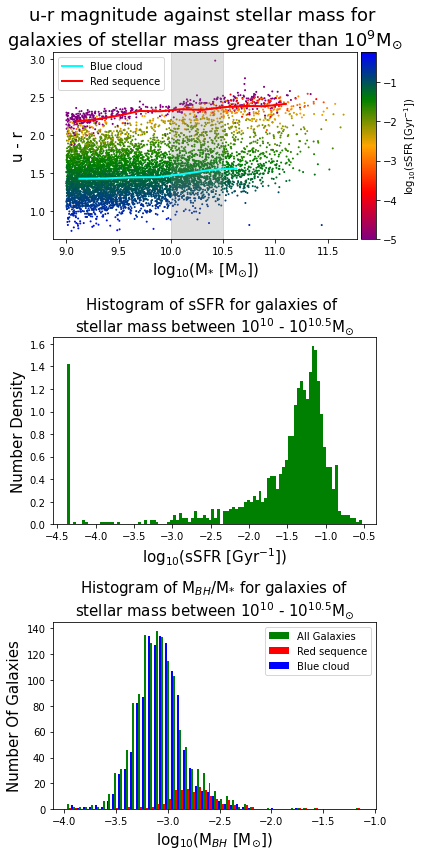

In [10]:
#cmap = plt.cm.gist_stern_r
#'''
cvals = [-2., -1, 0, 1, 2]
colors = ["purple","red","orange","green","blue"]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)
#'''

sSFR_1 = Data_1['ssfr']*10**9
LsSFR_1 = log_with_zeros(sSFR_1)
sSFR_2 = Data_2['ssfr']*10**9
LsSFR_2 = log_with_zeros(sSFR_2)
LRatio = log_with_zeros(Data_2['ratio'])
RB = redblue_split(LRatio, Data_2['ssfr'], 5.0e-12)
LRatio_r = RB[0]
LRatio_b = RB[1]
Lratios = np.array([LRatio, LRatio_r, LRatio_b], dtype = object)
Labels = ['All Galaxies', 'Red sequence', 'Blue cloud']

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (6,12))
im1 = ax1.scatter(Data_1['mass'], Data_1['u_minus_r'], s=1, c = LsSFR_1, cmap = cmap)
im2 = ax2.hist(LsSFR_2, bins = 100, density = True, rwidth = 1.0, color = 'g')
im3 = ax3.hist(Lratios, bins = 50, density = False, rwidth = 1.0, color = ['g','r','b'], label = Labels)
ax1.axvspan(10, 10.5, color='grey', alpha=0.25)

ax1.plot(bmeds[0], bmeds[1], linewidth = 2, color = 'cyan', label = 'Blue cloud')
ax1.plot(rmeds[0], rmeds[1], linewidth = 2, color = 'red', label = 'Red sequence')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = r'log$_{10}$(sSFR [Gyr$^{-1}$])')

ax1.set_title('u-r magnitude against stellar mass for \n' + r'galaxies of stellar mass greater than 10$^{9}$M$_{\odot}$', fontsize=18)
ax2.set_title('Histogram of sSFR for galaxies of \n' + r'stellar mass between 10$^{10}$ - 10$^{10.5}$M$_{\odot}$', fontsize=15)
ax3.set_title('Histogram of M$_{BH}$/M$_{*}$ for galaxies of \n' + r'stellar mass between 10$^{10}$ - 10$^{10.5}$M$_{\odot}$', fontsize=15)
ax1.set_xlabel(r'log$_{10}$(M$_{*}$ [M$_{\odot}$])', fontsize=15)
ax1.set_ylabel(r'u - r', fontsize=15)
ax2.set_xlabel(r'log$_{10}$(sSFR [Gyr$^{-1}$])', fontsize=15)
ax2.set_ylabel(r'Number Density', fontsize=15)
ax3.set_xlabel(r'log$_{10}$(M$_{BH}$ [M$_{\odot}$])', fontsize=15)
ax3.set_ylabel(r'Number Of Galaxies', fontsize=15)
ax1.legend()
ax3.legend()

plt.tight_layout()
plt.savefig('Plot_1.jpeg')
plt.show()